Implementing ridge classifier from sklearn package using Generalized Cross Vailidation to optimise L2 penalty coefficient alpha.

In [1]:
%pylab inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline
from collections import Counter

In [3]:
# Pull in training data
training_data = pd.read_csv('GSE68086_TEP_data_matrix.txt', sep='\t',index_col=0).T
training_data.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000273481,ENSG00000273483,ENSG00000273484,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
3-Breast-Her2-ampl,0,0,44,26,81,171,34,83,0,14,...,0,0,0,0,1,0,0,1,4,0
8-Breast-WT,0,0,14,1,98,99,0,107,0,5,...,0,0,0,0,0,0,0,0,0,0
10-Breast-Her2-ampl,0,0,16,14,18,25,0,62,4,13,...,0,0,0,0,0,0,0,0,0,0
Breast-100,0,0,8,0,17,4,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
15-Breast-Her2-ampl,17,0,9,4,0,49,0,40,0,10,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#pull differentially expressed genes 
dexp_data = pd.read_excel('mmc3.xlsx', skiprows=4)
diff_gene = dexp_data["Ensembl gene ID"]
#save whole training data
sv_training_data = training_data
#extract differentially expressed genes
training_data = training_data[training_data.columns.intersection(diff_gene)]
shape(training_data)

(285, 2246)

In [5]:
training_data["cancer"] = list(training_data.index)
training_data["cancer"] = training_data.cancer.str.extract(r'(Breast|BrCa|CRC|GBM|NSCLC|Lung|Chol|Liver|HBC|Panc|Unknown|HD|Control)')
training_data.loc[training_data.cancer =="Breast","cancer"] = "BrCa"
training_data.loc[training_data.cancer=="Lung","cancer"] = "NSCLC"
training_data.loc[training_data.cancer=="Chol","cancer"] = "HBC"
training_data.loc[training_data.cancer=="Liver","cancer"] = "HBC"
training_data.loc[training_data.cancer=="Panc","cancer"] = "PAAD"
training_data.loc[training_data.cancer=="Control","cancer"] = "HD"

/home/suiram/anaconda3/envs/week7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/suiram/anaconda3/envs/week7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/suiram/anaconda3/envs/week7/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [6]:
# Fix random seed for reproducibility
seed = 3
np.random.seed(seed)
# Exclude Unknown cases
# Get labels for training data
Y = training_data.cancer[training_data.cancer != "Unknown"] != "HD"

# Get training data as numpy array
X = training_data[training_data.cancer != "Unknown"].drop(['cancer'], axis=1).astype(float).values

In [7]:
# prepare datasets for test and training using oversampling
ros = RandomOverSampler(1,random_state=seed)
rus = RandomUnderSampler(1,random_state=seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
X_over, Y_over = ros.fit_resample(X_train, Y_train)

# summarize class distribution
print(Counter(Y_over))
print(X_over.shape)
print(Y_over.shape)



Counter({True: 162, False: 162})
(324, 2246)
(324,)


In [8]:
# tune alpha
ridg = linear_model.RidgeClassifierCV(alphas=np.logspace(-6, 12, 19))
ridg.fit(X_over, Y_over)
print('Generalized CV identified optimal parameter alpha=')
print(ridg.alpha_)
opt_alpha = ridg.alpha_





Generalized CV identified optimal parameter alpha=
100000000.0


In [9]:
#Evaluate performance
ridg = linear_model.RidgeClassifier(alpha=opt_alpha, random_state=seed).fit(X_over, Y_over)
training_scores = cross_val_score(ridg, X_over, Y_over, cv=5)
print("5-fold CV Training Accuracy: %0.2f (+/- %0.2f)" % (training_scores.mean(), training_scores.std() * 2))
#test_scores= cross_val_score(ridg, X_test, Y_test, cv=10)
#print("5-fold CV Test Accuracy: %0.2f (+/- %0.2f)" % (test_scores.mean(), test_scores.std() * 2))

5-fold CV Training Accuracy: 0.93 (+/- 0.05)


In [13]:
#Confusion Matrix
print('Confusion matrix Training data:')
print(metrics.confusion_matrix(Y_over, ridg.predict(X_over)))
print('Confusion matrix Test data')
print(metrics.confusion_matrix(Y_test, ridg.predict(X_test)))

Confusion matrix Training data:
[[162   0]
 [ 10 152]]
Confusion matrix Test data
[[19  1]
 [ 2 62]]


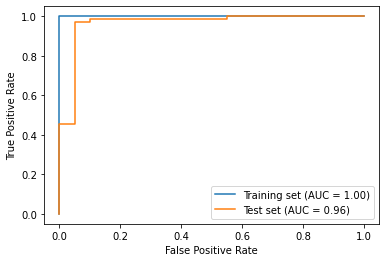

In [10]:
#plot roc curve
ax = plt.gca()
training_disp = plot_roc_curve(ridg, X_over, Y_over, name='Training set', ax=ax)
plot_roc_curve(ridg,X_test, Y_test, name='Test set', ax=ax)


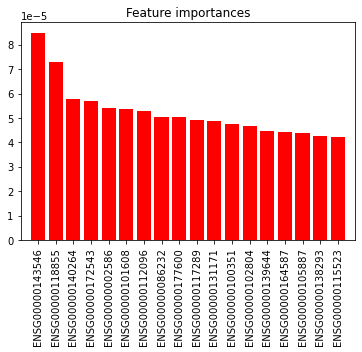

The 18 most important features are: 

Index(['ENSG00000143546', 'ENSG00000118855', 'ENSG00000140264',
       'ENSG00000172543', 'ENSG00000002586', 'ENSG00000101608',
       'ENSG00000112096', 'ENSG00000086232', 'ENSG00000177600',
       'ENSG00000117289', 'ENSG00000131171', 'ENSG00000100351',
       'ENSG00000102804', 'ENSG00000139644', 'ENSG00000164587',
       'ENSG00000105887', 'ENSG00000138293', 'ENSG00000115523'],
      dtype='object')


In [11]:
#get feature importance 
importances = abs(ridg.coef_)[0,:]
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(18),importances[indices][:18],color="r", align="center")
plt.xticks(range(18),training_data.T.index[indices][:18],rotation = 90)
plt.xlim([-1, 18])
plt.show()
print('The 18 most important features are: \n')
print(training_data.T.index[indices][:18])
